# Train- Data Loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms


## Train and Validation Dataset

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# /content/gdrive/MyDrive/Colab Notebooks/Dataset/Processed.zip

In [6]:
!unzip -q -o /content/gdrive/MyDrive/Colab\ Notebooks/Dataset/Processed.zip -d datasets


#### Loading npy files

In [7]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [8]:
train_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))
])

In [9]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [10]:
train_dataset = torchvision.datasets.DatasetFolder("/content/datasets/train/", loader=load_file, extensions="npy", transform=train_transforms)

In [11]:
val_dataset = torchvision.datasets.DatasetFolder("/content/datasets/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [12]:
type(train_dataset)

torchvision.datasets.folder.DatasetFolder

### Display Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


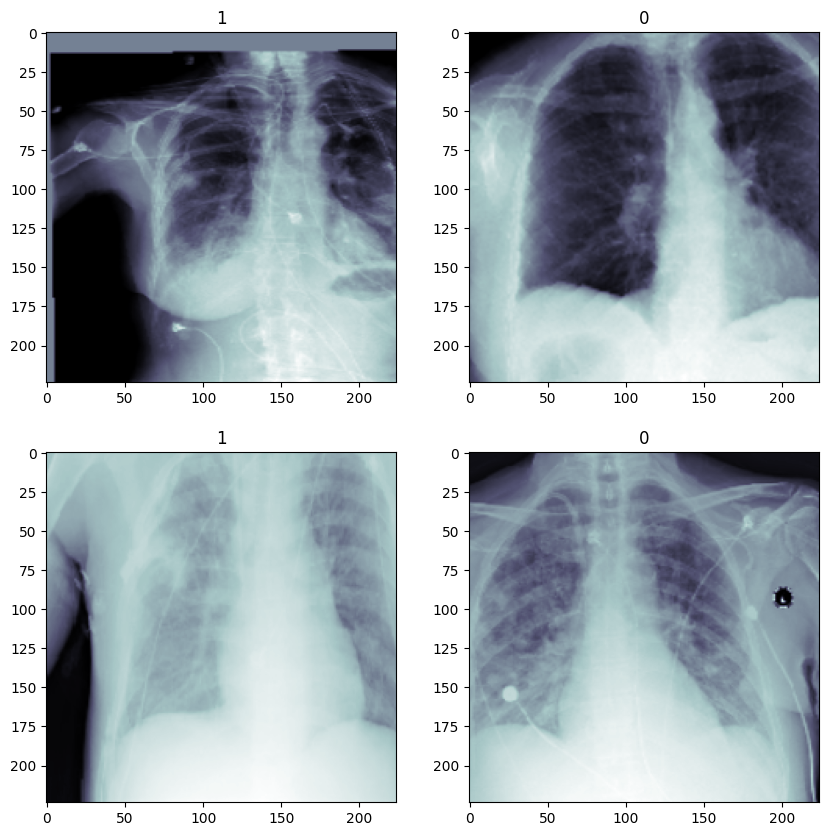

In [13]:
fig, axis = plt.subplots(2,2, figsize=(10,10))

for row in range(2):
  for column in range(2):
    random_index = np.random.randint(0,24000)
    x_ray, label = train_dataset[random_index]    # tuple unpacking
    axis[row][column].imshow(x_ray[0,:,:], cmap="bone")
    axis[row][column].set_title(label)


### Data Loader

In [14]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

# Define Model

In [16]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
# Change Input and Output shape

class PneumoniaModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

    # Optimizer and Loss
    # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    # self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

    # Trackers
    self.train_losses = []
    self.test_losses = []
    self.train_correct = []
    self.test_correct = []

  def forward(self, X):
    pred = self.model(X)
    return pred

In [28]:
model = PneumoniaModel()

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

## Train Model

In [35]:
import time

start_time = time.time()

Epochs = 1

# for loop Epochs
for epoch in range(Epochs):

  trn_corr = 0
  tst_corr = 0

  # Train
  for btch,(X_train, y_train) in enumerate(train_loader):

    y_pred = model(X_train)
    y_train = y_train.float()
    loss = loss_fn(y_pred, y_train.view(64,1))
    batch_corr = (y_pred==y_train.view(64,1)).sum()
    trn_corr += batch_corr

    # Backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if btch%10 == 0:
      print(f"EPOCH: {epoch+1} BATCH: {btch} LOSS: {loss.item()}")

  model.train_losses.append(loss)
  model.train_correct.append(trn_corr)

    # self.train_losses = []
    # self.test_losses = []
    # self.train_correct = []
    # self.test_correct = []






EPOCH: 1 BATCH: 0 LOSS: 0.7934499979019165
EPOCH: 1 BATCH: 10 LOSS: 0.9155481457710266
EPOCH: 1 BATCH: 20 LOSS: 0.7030347585678101
EPOCH: 1 BATCH: 30 LOSS: 0.6383612155914307
EPOCH: 1 BATCH: 40 LOSS: 0.7198187708854675
EPOCH: 1 BATCH: 50 LOSS: 0.818672239780426
EPOCH: 1 BATCH: 60 LOSS: 0.7466180324554443
EPOCH: 1 BATCH: 70 LOSS: 0.7817323803901672
EPOCH: 1 BATCH: 80 LOSS: 0.5747835040092468
EPOCH: 1 BATCH: 90 LOSS: 0.961609423160553
EPOCH: 1 BATCH: 100 LOSS: 0.7661009430885315
EPOCH: 1 BATCH: 110 LOSS: 0.8556112051010132
EPOCH: 1 BATCH: 120 LOSS: 0.9591217041015625
EPOCH: 1 BATCH: 130 LOSS: 0.8915624618530273
EPOCH: 1 BATCH: 140 LOSS: 0.795556366443634
EPOCH: 1 BATCH: 150 LOSS: 0.7342946529388428
EPOCH: 1 BATCH: 160 LOSS: 0.512366771697998
EPOCH: 1 BATCH: 170 LOSS: 0.892707347869873
EPOCH: 1 BATCH: 180 LOSS: 0.5626025199890137
EPOCH: 1 BATCH: 190 LOSS: 0.6481457352638245
EPOCH: 1 BATCH: 200 LOSS: 0.9498502612113953
EPOCH: 1 BATCH: 210 LOSS: 0.8293896913528442
EPOCH: 1 BATCH: 220 LOSS: 

In [ ]:
y_pred